In [3097]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from scipy.signal import welch

In [3098]:
c = 3.0*1e8  # (m/s)
density = 1850  # kg/m³ (SiO2)
kB = 1.380649e-23 # J/K
epsilon_0 = 8.854187817e-12 # (C^2)*(N^-1)*(m^-2)
n_md = 1  # medium refractive index
n_p = 1.46 # particle refractive index
R = 75e-9  # particle radius (m)
T = 297 # K
lamb = 1064*1e-9  # (m)
NA = 0.77
P = 250*1e-3 # Total Power (W), and here I'm considering that the two beams are of same power, half of P actually
m_gas = 4.81e-26 # molecular mass of air
Pressure_atm = 1013.25 #mbar (=1 atm)
Pressure = 1013.25/1013.250000
eta_air = 18.27e-6 # Pa # (J.T.R.Watson (1995)).
d_gas = 0.372e-9 #m #(Sone (2007)), ρSiO2

In [3099]:
print(Pressure, "milibar")

1.0 milibar


In [3100]:
k = 2*np.pi/lamb
w_0 = lamb/(np.pi*NA) # incident beam waist (m)
m_rri = n_p/n_md #relative refractive index
z_R = (np.pi * w_0**2) / lamb #rayleigh range #checar isso aqui!!!!!!!!!!!!!!!
volume = (4/3) * np.pi * (R**3)
m = density * volume  # kg

In [3101]:
def Gamma_env(Pressure_mbar):
    def mfp(P_gas):
        mfp_val = kB*T/(2**0.5*np.pi*d_gas**2*P_gas)
        return mfp_val
    
    Pressure_pascals = 100*Pressure_mbar
    s = mfp(Pressure_pascals)
    K_n = s/R
    c_K = 0.31*K_n/(0.785 + 1.152*K_n + K_n**2)
    gamma = 6*np.pi*eta_air*R/m * 0.619/(0.619 + K_n) * (1+c_K)
    return gamma #Isso está em Hz

def R_curv(z):
    z_safe = np.where(z == 0, 1e-30, z)       #Isso aqui impede que o código quebre em z = 0 substituindo esse
    return z_safe*(1+((z_R**2)/(z_safe**2)))  #ponto por um outro valor muito pequeno diferente de zero.

def gouy_phase(z):
    return np.arctan(z/z_R)

def w(z):
    return w_0*((1+((z**2)/(z_R**2)))**(1/2))

def I(E):
    return c*epsilon_0*(abs(E)**2)/2

In [3102]:
N = 1_000_000
dt = 1e-9
t = np.linspace(0,dt*N,N)
gamma_hz = Gamma_env(Pressure)

x = np.linspace(-3*w_0,3*w_0,len(t))
y = np.linspace(-3*w_0,3*w_0,len(t))
z = np.linspace(-3*z_R,3*z_R,len(t))

In [3103]:
def E(x,y,z):
    E_0 = (np.sqrt(P/(np.pi*(w_0**2)*c*epsilon_0)))
    return E_0*(w_0/w(z))*np.exp((-((x**2)+(y**2)))/(w(z)**2))*np.exp(-1j*(k*(z)+k*(((x**2)+(y**2))/(2*R_curv(z))) - gouy_phase(z)))

def I(E):
    return c*epsilon_0*(abs(E)**2)/2

In [3104]:
I_z = I(E(0, 0, z))
I_x = I(E(x, 0, 0))
I_y = I(E(0, y, 0))

F_scatt_z = ((128*(np.pi**5)*(n_md**5)*(R**6))/(3*c*(lamb**4)))*((((m_rri**2)-1)/((m_rri**2)+2))**2)*I_z

F_grad_x = (2*np.pi*n_md*(R**3)/c)*(((m_rri**2)-1)/((m_rri**2)+2))*np.gradient(I_x, x)
F_grad_y = (2*np.pi*n_md*(R**3)/c)*(((m_rri**2)-1)/((m_rri**2)+2))*np.gradient(I_y, y)
F_grad_z = (2*np.pi*n_md*(R**3)/c)*(((m_rri**2)-1)/((m_rri**2)+2))*np.gradient(I_z, z)

F_total_x = F_grad_x
F_total_y = F_grad_y
F_total_z = F_grad_z #+ F_scatt_z

In [3105]:
@njit(fastmath=True)
def dx_dt(v):
    return v

@njit(fastmath=True)
def dv_dt(pos, F_total, v, t):
    gain = 0.5
    freq_nat = 176_000  # frequência natural em Hz
    omega_mod = 4 * np.pi * freq_nat  # frequência angular de modulação = 2 * omega_0
    phase_shift = 0 #np.pi/2

    modulation = np.abs(np.sin(omega_mod * t + phase_shift))
    return (F_total / m) * (1 + gain * modulation) - gamma_hz * v

In [3106]:
@njit(fastmath=True)
def runge_kutta(v_init, pos_init):
    positions = np.zeros((len(t), 3))
    velocities = np.zeros((len(t), 3))
    
    positions[0, :] = pos_init
    velocities[0, :] = v_init

    for i in range(len(t) - 1):
        Fx = np.interp(positions[i, 0], x, F_total_x)
        Fy = np.interp(positions[i, 1], y, F_total_y)
        Fz = np.interp(positions[i, 2], z, F_total_z)
        
        Fs = np.array([Fx, Fy, Fz])

        k1_pos = velocities[i] * dt
        k1_v = np.array([dv_dt(positions[i, j], Fs[j], velocities[i, j], i*dt) for j in range(3)]) * dt

        k2_pos = (velocities[i] + 0.5 * k1_v) * dt
        k2_v = np.array([dv_dt(positions[i, j] + 0.5 * k1_pos[j], Fs[j], velocities[i, j] + 0.5 * k1_v[j], i*dt) for j in range(3)]) * dt

        k3_pos = (velocities[i] + 0.5 * k2_v) * dt
        k3_v = np.array([dv_dt(positions[i, j] + 0.5 * k2_pos[j], Fs[j], velocities[i, j] + 0.5 * k2_v[j], i*dt) for j in range(3)]) * dt

        k4_pos = (velocities[i] + k3_v) * dt
        k4_v = np.array([dv_dt(positions[i, j] + k3_pos[j], Fs[j], velocities[i, j] + k3_v[j], i*dt) for j in range(3)]) * dt

        positions[i + 1] = positions[i] + (1.0 / 6.0) * (k1_pos + 2 * k2_pos + 2 * k3_pos + k4_pos)
        velocities[i + 1] = velocities[i] + (1.0 / 6.0) * (k1_v + 2 * k2_v + 2 * k3_v + k4_v)

        thermal_noise = np.sqrt(2 * kB * T * gamma_hz * m) * np.random.normal(0, 1, 3) * np.sqrt(dt) / m
        velocities[i + 1] += thermal_noise

    return positions, velocities


In [3107]:
x0 = np.array([0.0, 0.0, 0.0])
v0 = np.array([0.0, 0.0, 0.0])
fs = 1 / dt

P,V,F = [],[],[]

PSDs = []
num_PSD = 1
for i in range(num_PSD):
    positions, velocities = runge_kutta(v0, x0)
    P.append(positions)
    V.append(velocities)

    f, Pxx = welch(positions[:,0], fs=fs, window='hamming', nperseg=len(positions[:,0]))
    f, Pyy = welch(positions[:,1], fs=fs, window='hamming', nperseg=len(positions[:,1]))
    f, Pzz = welch(positions[:,2], fs=fs, window='hamming', nperseg=len(positions[:,2]))
    
    F.append(f)
    PSDs.append([Pxx,Pyy,Pzz])

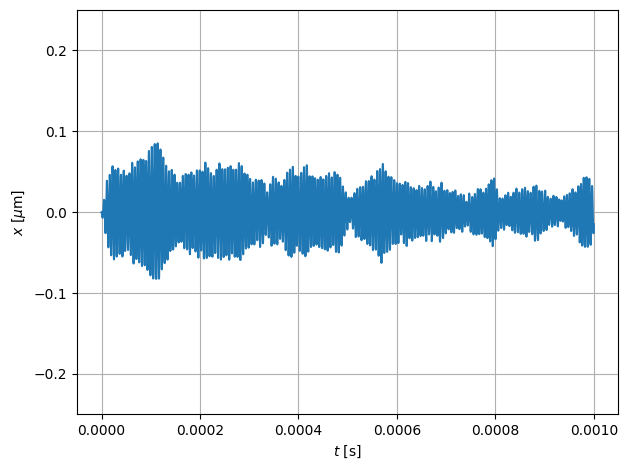

In [3108]:
l=0

plt.plot(t, P[l][:,2] * 1e6, color='#1f77b4')
plt.ylim(-0.25, 0.25)
plt.xlabel(r'$t\ \left[\mathrm{s}\right]$')
plt.ylabel(r'$x\ \left[\mu\mathrm{m}\right]$')
plt.grid(True)

plt.tight_layout()
plt.show()

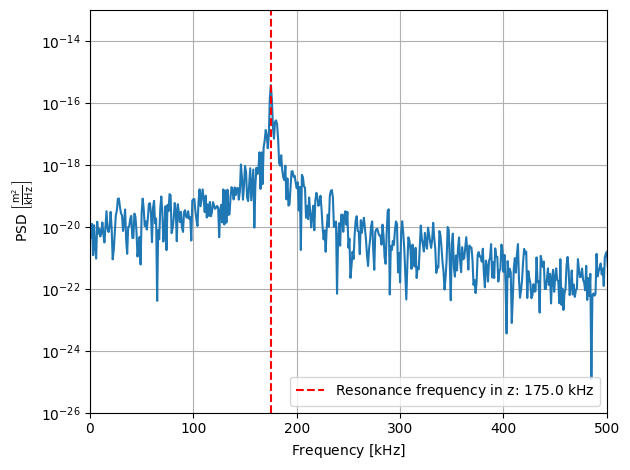

In [3109]:
idx_max_z = np.argmax(Pzz[25:]) + 25
f_max = f[idx_max_z]

plt.plot(f[1:]/1e3,Pzz[1:]*1e3)
plt.yscale('log')
#plt.xscale('log')
plt.ylim(1e-26,1e-13)
plt.xlim(0,0.5e6/1e3)
plt.xlabel(r'Frequency $\left[\mathrm{kHz}\right]$')
plt.ylabel(r'PSD $\left[\frac{\mathrm{m}^2}{\mathrm{kHz}}\right]$')
plt.axvline(f_max/1e3, color='r', linestyle='--',label=fr'Resonance frequency in z: {f_max/1e3:.1f} $\mathrm{{kHz}}$')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()